# Synthetic V1: Klein bottle

Lead author: Sofia Gonzalez.

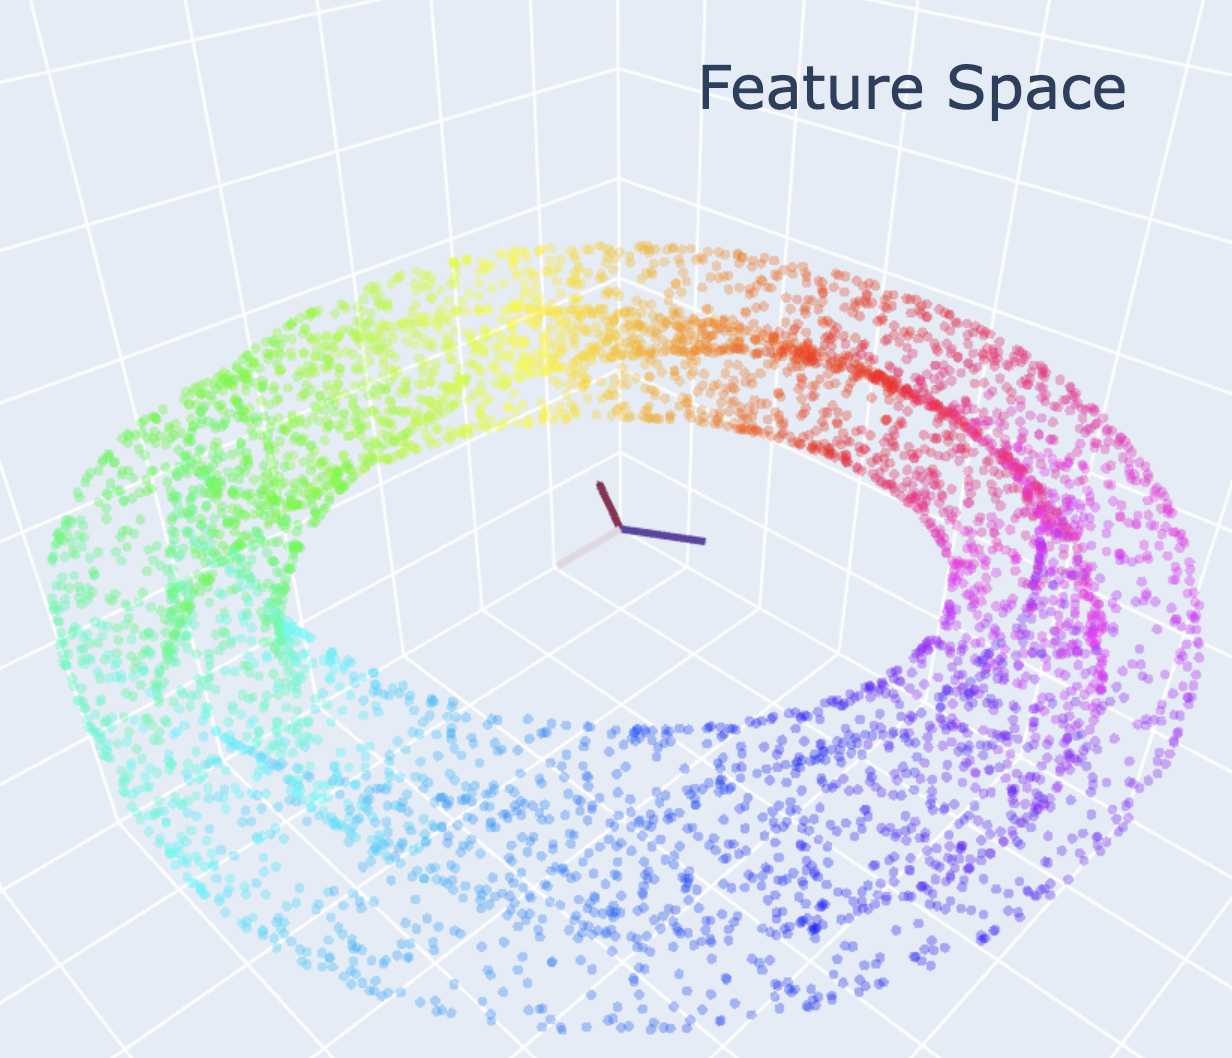


The Klein bottle may be constructed from the symmetry properties of simple cell receptive fields in V1 (See _Looking into a Klein bottle_ by _Nicholas V. Swindale_). <br>
The notion of Klein bottle, written $\mathbb{K}$, refers to any topological space homeomorphic to that obtained by identification in a full square of the opposite sides with a change of direction for one of the pairs. Group theoretically speaking:<br>
\begin{align*}
         &  (x_1,y_1) \sim (x_2, y_2) \\
         \Leftrightarrow \quad &  y_1-y_2 \in \mathbb Z
                                 \text{ and } x_1-x_2 \in 2\mathbb Z \\
         \text{ or } \quad &
        y_1 + y_2 \in \mathbb Z \text{ and } x_1-x_2 \in \mathbb Z\setminus 2\mathbb Z.
\end{align*}

The intrinsic dimension of the Klein function is 2. This is what _geomstats_ outputs by default when generating random points on its surface. However, we can play with its different parametrizations to work with it in a more intuitive way. It cannot be embedded in $\mathbb{R}^3$, but only immerged with a self-intersection. The smallest number of dimensions required to embed the Klein bottle is 4. <br>
However, we can construct different parametrizations in $\mathbb{R}^3$ in order to visualize its properties better. The three main 3D parametrizations are: <br>
- Klein bottle
- Klein bagel
- Pinched torus

### Set-up + Imports

In [2]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch

Working directory:  /home/sghomedir/Desktop/github/neurometry/neurometry
Directory added to path:  /home/sghomedir/Desktop/github/neurometry
Directory added to path:  /home/sghomedir/Desktop/github/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Klein bagel parametrization

In [3]:
num_points = 5000
task_points = synthetic.klein_bottle(num_points, coords_type="bagel")

noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array(np.ones(3)),
    poisson_multiplier=50,
)

print("Initial dimension (task points):", np.shape(task_points)[1])
print("Dimension of manifold/noisy points:", np.shape(noisy_points)[1])

Initial dimension (task points): 3
Dimension of manifold/noisy points: 3


In [4]:
def plot_feature_neural_spaces(
    task_points, noisy_points, range_ax, pt_size=2, opacity=0.5, N=3
):
    x = task_points[:, 0]
    y = task_points[:, 1]
    z = task_points[:, 2]
    angles = torch.atan2(task_points[:, 1], task_points[:, 0])
    normalized_angles = angles / (2 * np.pi) + 1 / 2
    colors = plt.cm.hsv(normalized_angles)

    place_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    encoding_matrix = gs.vstack((gs.cos(place_angles), gs.sin(place_angles)))
    vectors = [encoding_matrix[:, i] for i in range(N)]

    cm = plt.get_cmap("twilight")
    vector_colors = [cm(1.0 * i / N) for i in range(N)]
    vector_colors = [
        "rgb({}, {}, {})".format(int(r * 255), int(g * 255), int(b * 255))
        for r, g, b, _ in vector_colors
    ]

    scatter1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(size=pt_size, color=colors, opacity=opacity),
        name="Data Points",
    )

    lines_and_cones = []
    for idx, (vector, color) in enumerate(zip(vectors, vector_colors)):
        lines_and_cones.append(
            go.Scatter3d(
                x=[0, vector[0]],
                y=[0, vector[1]],
                z=[0, 0],
                mode="lines",
                line=dict(color=color, width=5),
                name=f"Encoding Vector {idx+1}",
            )
        )
    lines_and_cones.append(
        go.Cone(
            x=[vector[0]],
            y=[vector[1]],
            z=[0],
            u=[vector[0] / 10],
            v=[vector[1] / 10],
            w=[0],
            showscale=False,
            colorscale=[[0, color], [1, color]],
            sizemode="absolute",
            sizeref=0.1,
        )
    )

    x = noisy_points[:, 0]
    y = noisy_points[:, 1]
    z = noisy_points[:, 2]

    print(f"mean firing rate: {torch.mean(noisy_points):.2f} Hz")

    scatter2 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(size=pt_size, color=colors, opacity=opacity),
        name="Neural activations",
    )

    fig = make_subplots(
        rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
    )

    # Add the first set of traces (scatter1 and lines_and_cones) to the first subplot
    fig.add_traces(
        [scatter1] + lines_and_cones,
        rows=[1] * (len([scatter1]) + len(lines_and_cones)),
        cols=[1] * (len([scatter1]) + len(lines_and_cones)),
    )

    # Add the second scatter (scatter2) to the second subplot
    fig.add_trace(scatter2, row=1, col=2)

    reference_frequency = 200

    fig.update_layout(
        scene1=dict(
            aspectmode="cube",
            xaxis=dict(range=[-range_ax, range_ax], title="Feature 1"),
            yaxis=dict(range=[-range_ax, range_ax], title="Feature 2"),
            zaxis=dict(range=[-range_ax, range_ax], title=""),
        ),
        scene2=dict(
            aspectmode="cube",
            xaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 1 firing rate",
            ),
            yaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 2 firing rate",
            ),
            zaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 3 firing rate",
            ),
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        title_text="",
        annotations=[
            dict(
                text="Feature Space",
                xref="paper",
                yref="paper",
                x=0.25,
                y=0.95,
                showarrow=False,
                font=dict(size=20),
            ),
            dict(
                text="Neural Space",
                xref="paper",
                yref="paper",
                x=0.75,
                y=0.95,
                showarrow=False,
                font=dict(size=20),
            ),
        ],
    )

    fig.show()

mean firing rate: 100.24 Hz


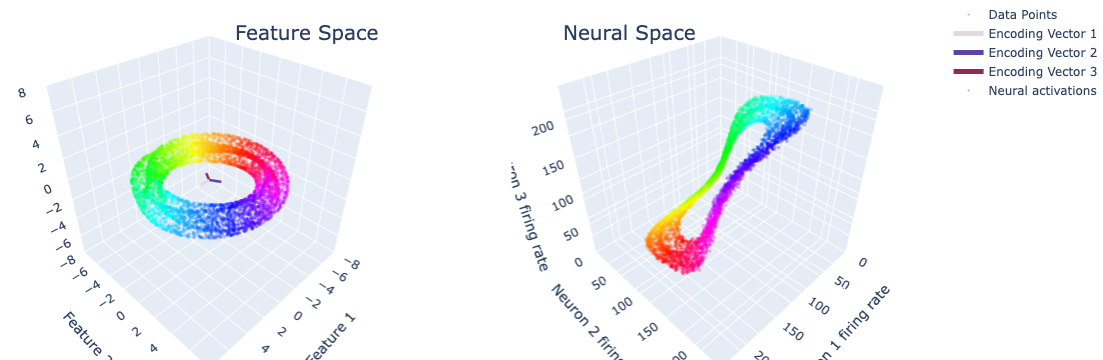

In [5]:
range_ax = 8
pt_size = 2
opacity = 0.3

plot_feature_neural_spaces(task_points, noisy_points, range_ax, pt_size, opacity)

### Klein bottle parametrization

In [6]:
num_points = 5000
task_points = synthetic.klein_bottle(num_points, coords_type="bottle")
task_points -= gs.mean(task_points)

noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array(np.ones(3)),
    poisson_multiplier=100,
)

print("Initial dimension (task points):", np.shape(task_points)[1])
print("Dimension of manifold/noisy points:", np.shape(noisy_points)[1])

Initial dimension (task points): 3
Dimension of manifold/noisy points: 3


In [7]:
range_ax = 4
pt_size = 2
opacity = 0.3

plot_feature_neural_spaces(task_points, noisy_points, range_ax, pt_size, opacity)

mean firing rate: 109.97 Hz
